In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.
/Users/xuwenshen/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [19]:
train.head(7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [21]:
train[train['identity_hate'] == 1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1
429,01166f26ee280e56,Gay \n\nThe existence of CDVF is further proof...,1,0,1,0,1,1
521,015d1b0bb4cc744d,Dictionaries\n\nHow dare you call my contribut...,1,0,1,0,1,1
887,026bd33490542b2e,"you gay motherfucker i know where you live,i a...",1,1,1,0,1,1
952,029dceed3519e371,you studid cock sucker u stop callin me ok its...,1,0,1,0,1,1
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1


In [15]:
# detect NAs
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [23]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]
#y = train[list_classes].values

In [24]:
max_features = 20000
#  tokenization will be restricted to the top max_feature (20000) most common words in the dataset
tokenizer = Tokenizer(num_words=max_features) # Initialize a tokenizer
tokenizer.fit_on_texts(list(list_sentences_train)) #tokenize the text 

In [27]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test) 
#index representation of all the list texts

In [29]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [30]:
inp = Input(shape=(maxlen, ))

In [33]:
# Step 2:Why 128
# 128: the demension of the output (embedding)
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x

<tf.Tensor 'embedding_3/Gather:0' shape=(?, 200, 128) dtype=float32>

In [34]:
# Step 3: LSTM 
# 60: the demension of the output layer
# why 60?
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)


In [35]:
x = GlobalMaxPool1D()(x)

In [37]:
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [38]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1705s 12ms/step - loss: 0.0508 - acc: 0.9816 - val_loss: 0.0501 - val_acc: 0.9821
Epoch 2/2
 14176/143613 [=>............................] - ETA: 25:33 - loss: 0.0421 - acc: 0.9842

Interview Questions
1. How RNN works?
    RNN can be thought of as nn performing the same task for every element of a sequence, with the output being depended on the previous computations.
    applying the same set of weights recursively over a differentiable graph-like structure. (W is the same)

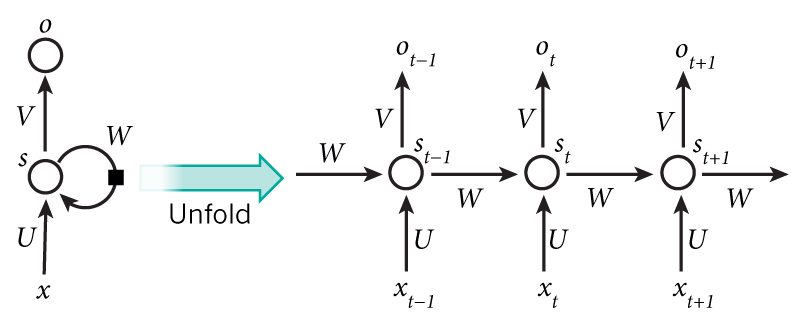

In [3]:
from IPython.display import Image
Image("rnn_unroll.jpg")


2. gradient valish
    the information flowing through neural nets passes through many stages of multiplication. This is why we use LSTM
3. LSTM
    Main difference from normal rnn:
    When determin the state of the cell, we dont multiply the state with the new input, we add the two instead.
    The change helps preserve a constant error when it must be backpropagated at depth!!
 